# Stock Data Collection and Cleaning for Direction Prediction

## Objective
This notebook fetches historical stock data for 20 selected companies and performs cleaning operations with a focus on preparing data for **direction prediction** rather than exact price prediction. The cleaned datasets will be saved to `data/cleaned/` for further processing by model-specific preparation notebooks.

## Purpose
The goal is to create a clean dataset with appropriate features and multiple target variables for different prediction horizons, but focusing on price movement direction rather than exact prices:
- Next day price direction (up or down)
- Next week price direction (up or down)
- Next month price direction (up or down)

Each of these targets will be used to train separate specialized models, allowing for higher accuracy across different prediction timeframes.

## Steps:
1. Import necessary libraries
2. Define companies list
3. Fetch historical data using yfinance
4. Perform basic cleaning
5. Add direction prediction targets for multiple timeframes
6. Visualize the data
7. Save cleaned datasets
8. Perform data quality checks

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta
import warnings
from tqdm.notebook import tqdm

# Set display options
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
%matplotlib inline

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## 1. Define Stock List

We'll use a predefined list of 20 companies representing different sectors for our analysis. This provides a diverse dataset for model training.

In [2]:
# Define list of companies with symbols
stocks = [
    "AAPL", "MSFT", "GOOG", "AMZN", "TSLA", 
    "META", "NVDA", "SPY", "V", "DIS", 
    "NFLX", "PYPL", "BABA", "IBM", "AMD", 
    "BA", "INTC", "T", "GS", "NKE"
]
    
print(f"Total stocks to analyze: {len(stocks)}")

Total stocks to analyze: 20


## 2. Create Output Directory

Define and create the directory where cleaned data will be stored.

In [3]:
# Create output directory if it doesn't exist
output_dir = '../data/cleaned/'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {os.path.abspath(output_dir)}")

Output directory: /home/abderrahmane/Stock-Market-Predictor/ml/data/cleaned


## 3. Define Data Fetching Function

This function fetches historical data for a given stock ticker using the yfinance library. We'll retrieve 10 years of data to ensure we have sufficient history for training our models.

In [4]:
def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch historical stock data for a given ticker symbol.
    
    Parameters:
    - ticker: Stock symbol
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame with historical stock data
    """
    
    try:
        # Fetch data using yfinance
        stock = yf.Ticker(ticker)
        df = stock.history(start=start_date, end=end_date)
        
        # Check if we got any data
        if df.empty:
            print(f"No data found for {ticker}")
            return None
        
        # Add ticker column
        df['Symbol'] = ticker
        
        # Get company info for additional metadata
        try:
            info = stock.info
            df['Sector'] = info.get('sector', 'Unknown')
            df['Industry'] = info.get('industry', 'Unknown')
        except:
            print(f"Could not retrieve company info for {ticker}")
            df['Sector'] = 'Unknown'
            df['Industry'] = 'Unknown'
        
        print(f"Successfully fetched data for {ticker}: {len(df)} rows")
        return df
    
    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")
        return None

## 4. Define Data Cleaning Function

This function performs essential cleaning operations and feature engineering on the raw stock data. Key components include:

1. Basic cleaning (standardizing column names, handling missing values)
2. Feature engineering (moving averages, volatility, returns)
3. Creating prediction targets for three different time horizons, focusing on **direction** rather than exact prices:
   - Next day price direction (1 = up, 0 = down)
   - Next week price direction (1 = up, 0 = down)
   - Next month price direction (1 = up, 0 = down)

In [5]:
def clean_stock_data(df):
    """
    Perform basic cleaning operations on stock data and create direction prediction targets.
    
    Parameters:
    - df: DataFrame with stock data
    
    Returns:
    - Cleaned DataFrame with direction prediction targets
    """
    if df is None or df.empty:
        return None
    
    # Make a copy to avoid modifying the original DataFrame
    df_clean = df.copy()
    
    # Reset index to make Date a column
    df_clean = df_clean.reset_index()
    
    # Ensure Date column is datetime
    df_clean['Date'] = pd.to_datetime(df_clean['Date'])
    
    # Rename columns to standard format
    df_clean = df_clean.rename(columns={
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Volume': 'volume',
        'Dividends': 'dividends',
        'Stock Splits': 'splits',
        'Symbol': 'symbol',
        'Date': 'date'
    })
    
    # Handle missing values
    df_clean[['open', 'high', 'low', 'close']] = df_clean[['open', 'high', 'low', 'close']].fillna(method='ffill')
    df_clean['volume'] = df_clean['volume'].fillna(0)
    df_clean['dividends'] = df_clean['dividends'].fillna(0)
    df_clean['splits'] = df_clean['splits'].fillna(0)
    
    # Add derived features
    df_clean['return'] = df_clean['close'].pct_change()  # Daily returns
    
    # Moving averages
    df_clean['ma5'] = df_clean['close'].rolling(window=5).mean()
    df_clean['ma20'] = df_clean['close'].rolling(window=20).mean()
    df_clean['ma50'] = df_clean['close'].rolling(window=50).mean()
    
    # Price to MA ratios (useful for trend direction)
    df_clean['price_to_ma5'] = df_clean['close'] / df_clean['ma5']
    df_clean['price_to_ma20'] = df_clean['close'] / df_clean['ma20']
    df_clean['price_to_ma50'] = df_clean['close'] / df_clean['ma50']
    
    # MA crossovers (useful for trend changes)
    df_clean['ma5_cross_ma20'] = (df_clean['ma5'] > df_clean['ma20']).astype(int)
    df_clean['ma20_cross_ma50'] = (df_clean['ma20'] > df_clean['ma50']).astype(int)
    
    # Volatility and volume features
    df_clean['volatility'] = df_clean['return'].rolling(window=20).std()
    df_clean['volume_ma20'] = df_clean['volume'].rolling(window=20).mean()
    df_clean['rel_volume'] = df_clean['volume'] / df_clean['volume_ma20']
    
    # Date features
    df_clean['day_of_week'] = df_clean['date'].dt.dayofweek
    df_clean['month'] = df_clean['date'].dt.month
    df_clean['year'] = df_clean['date'].dt.year
    
    # RSI (Relative Strength Index) - simple version
    delta = df_clean['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df_clean['rsi'] = 100 - (100 / (1 + rs))
    
    # Handle NaN values created by rolling calculations
    df_clean = df_clean.fillna(method='bfill')
    df_clean = df_clean.dropna()
    
    # Drop rows with extreme values (potential data errors)
    df_clean = df_clean[(df_clean['return'] > -0.5) & (df_clean['return'] < 0.5)]
    
    # Create the next day close price (for reference)
    df_clean['next_day_close'] = df_clean['close'].shift(-1)
    
    # Create direction prediction targets for multiple timeframes
    # 1. Next day direction (1 = up, 0 = down)
    df_clean['next_day_direction'] = (df_clean['next_day_close'] > df_clean['close']).astype(int)
    
    # 2. Next week direction (comparing current close with average close of next 5 trading days)
    shifted_close = pd.Series(df_clean['close'].values)
    next_week_avgs = []
    for i in range(len(shifted_close)):
        if i + 5 < len(shifted_close):
            next_week_avgs.append(shifted_close[i+1:i+6].mean())
        else:
            next_week_avgs.append(np.nan)
    df_clean['next_week_avg'] = next_week_avgs
    df_clean['next_week_direction'] = (df_clean['next_week_avg'] > df_clean['close']).astype(int)
    
    # 3. Next month direction (comparing current close with average close of next 21 trading days)
    next_month_avgs = []
    for i in range(len(shifted_close)):
        if i + 21 < len(shifted_close):
            next_month_avgs.append(shifted_close[i+1:i+22].mean())
        else:
            next_month_avgs.append(np.nan)
    df_clean['next_month_avg'] = next_month_avgs
    df_clean['next_month_direction'] = (df_clean['next_month_avg'] > df_clean['close']).astype(int)
    
    # Drop rows with NaN prediction targets (last 21 days of data)
    df_clean = df_clean.dropna()
    
    return df_clean

## 5. Define Visualization Function

This function creates visualizations to help understand the data and verify the cleaning process was successful. The visualizations now focus on direction prediction rather than exact price prediction.

In [6]:
def visualize_stock_data(df, ticker):
    """
    Create visualizations for the stock data with a focus on direction prediction.
    
    Parameters:
    - df: DataFrame with stock data
    - ticker: Stock symbol
    """
    if df is None or df.empty:
        print(f"No data to visualize for {ticker}")
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(4, 1, figsize=(14, 20))
    
    # Plot 1: Price history with moving averages
    axes[0].plot(df['date'], df['close'], label='Close Price')
    axes[0].plot(df['date'], df['ma20'], label='20-day MA', alpha=0.7)
    axes[0].plot(df['date'], df['ma50'], label='50-day MA', alpha=0.7)
    axes[0].set_title(f'{ticker} - Price History with Moving Averages')
    axes[0].set_ylabel('Price ($)')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot 2: Volume and RSI
    ax2 = axes[1]
    ax2.bar(df['date'], df['volume'], alpha=0.3, color='blue')
    ax2.set_ylabel('Volume', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_title(f'{ticker} - Volume and RSI')
    
    ax2b = ax2.twinx()
    ax2b.plot(df['date'], df['rsi'], color='red', alpha=0.7)
    ax2b.axhline(y=70, color='green', linestyle='--', alpha=0.5)  # Overbought line
    ax2b.axhline(y=30, color='green', linestyle='--', alpha=0.5)  # Oversold line
    ax2b.set_ylabel('RSI', color='red')
    ax2b.tick_params(axis='y', labelcolor='red')
    ax2.grid(True)
    
    # Plot 3: Returns and Volatility
    ax3 = axes[2]
    ax3.plot(df['date'], df['return'], label='Daily Returns', alpha=0.5, color='green')
    ax3.set_ylabel('Returns', color='green')
    ax3.tick_params(axis='y', labelcolor='green')
    ax3.set_title(f'{ticker} - Returns and Volatility')
    
    ax3b = ax3.twinx()
    ax3b.plot(df['date'], df['volatility'], label='Volatility (20-day)', color='red', alpha=0.7)
    ax3b.set_ylabel('Volatility', color='red')
    ax3b.tick_params(axis='y', labelcolor='red')
    
    lines1, labels1 = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3b.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    ax3.grid(True)
    
    # Plot 4: Direction Prediction Targets (visualization for last 90 days)
    last_90_days = df.iloc[-90:].copy()  # Focus on last 90 days for clarity
    
    # Create shaded regions for direction prediction
    ax4 = axes[3]
    ax4.plot(last_90_days['date'], last_90_days['close'], label='Close Price', color='black')
    
    # Color the background based on next day direction
    for i in range(len(last_90_days)-1):
        if last_90_days.iloc[i]['next_day_direction'] == 1:  # Up prediction
            ax4.axvspan(last_90_days.iloc[i]['date'], last_90_days.iloc[i+1]['date'], 
                        alpha=0.2, color='green')
        else:  # Down prediction
            ax4.axvspan(last_90_days.iloc[i]['date'], last_90_days.iloc[i+1]['date'], 
                        alpha=0.2, color='red')
    
    ax4.set_title(f'{ticker} - Price with Next-Day Direction (Green=Up, Red=Down)')
    ax4.set_ylabel('Price ($)')
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Prediction Target Distribution
    plt.figure(figsize=(14, 6))
    
    # Direction prediction distribution
    labels = ['Down (0)', 'Up (1)']
    
    # Create a 1x3 subplot for the three direction targets
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Next day direction
    day_counts = df['next_day_direction'].value_counts()
    day_pct = 100 * day_counts / len(df)
    axes[0].bar([0, 1], [day_counts.get(0, 0), day_counts.get(1, 0)], color=['red', 'green'])
    axes[0].set_title(f'Next Day Direction\nUp: {day_pct.get(1, 0):.1f}%, Down: {day_pct.get(0, 0):.1f}%')
    axes[0].set_xticks([0, 1])
    axes[0].set_xticklabels(labels)
    axes[0].set_ylabel('Count')
    
    # Next week direction
    week_counts = df['next_week_direction'].value_counts()
    week_pct = 100 * week_counts / len(df)
    axes[1].bar([0, 1], [week_counts.get(0, 0), week_counts.get(1, 0)], color=['red', 'green'])
    axes[1].set_title(f'Next Week Direction\nUp: {week_pct.get(1, 0):.1f}%, Down: {week_pct.get(0, 0):.1f}%')
    axes[1].set_xticks([0, 1])
    axes[1].set_xticklabels(labels)
    
    # Next month direction
    month_counts = df['next_month_direction'].value_counts()
    month_pct = 100 * month_counts / len(df)
    axes[2].bar([0, 1], [month_counts.get(0, 0), month_counts.get(1, 0)], color=['red', 'green'])
    axes[2].set_title(f'Next Month Direction\nUp: {month_pct.get(1, 0):.1f}%, Down: {month_pct.get(0, 0):.1f}%')
    axes[2].set_xticks([0, 1])
    axes[2].set_xticklabels(labels)
    
    plt.tight_layout()
    plt.suptitle(f"{ticker} - Direction Prediction Target Distribution", y=1.05, fontsize=16)
    plt.show()
    
    # Correlation matrix with a focus on predictive features and targets
    plt.figure(figsize=(14, 12))
    features = ['close', 'return', 'ma5', 'ma20', 'ma50', 'price_to_ma5', 'price_to_ma20',
                'ma5_cross_ma20', 'ma20_cross_ma50', 'volatility', 'rel_volume', 'rsi',
                'next_day_direction', 'next_week_direction', 'next_month_direction']
    
    corr = df[features].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')
    
    plt.title(f'{ticker} - Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

## 6. Fetch and Clean Data for All Stocks

Now we'll fetch and clean data for all stocks in our list, creating standardized datasets ready for direction prediction model preparation.

In [7]:
# Define date range (10 years of data)
end_date = datetime.now()
start_date = end_date - timedelta(days=365*10)  # 10 years

print(f"Fetching data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

# Process each stock
results = {}

for ticker in tqdm(stocks, desc="Processing stocks"):
    print(f"\nProcessing {ticker}...")
    
    # Fetch data
    df = fetch_stock_data(ticker, start_date, end_date)
    
    if df is not None and not df.empty:
        # Clean data
        cleaned_df = clean_stock_data(df)
        
        if cleaned_df is not None and not cleaned_df.empty:
            results[ticker] = cleaned_df
            print(f"Cleaned data shape for {ticker}: {cleaned_df.shape}")
            
            # Save cleaned data
            output_file = os.path.join(output_dir, f"{ticker}.csv")
            cleaned_df.to_csv(output_file, index=False)
            print(f"Saved cleaned data to {output_file}")
            
            # Print class distribution for direction prediction
            day_up_pct = 100 * cleaned_df['next_day_direction'].mean()
            week_up_pct = 100 * cleaned_df['next_week_direction'].mean()
            month_up_pct = 100 * cleaned_df['next_month_direction'].mean()
            
            print(f"Direction prediction class distribution:")
            print(f"  - Next day: {day_up_pct:.1f}% Up, {100-day_up_pct:.1f}% Down")
            print(f"  - Next week: {week_up_pct:.1f}% Up, {100-week_up_pct:.1f}% Down")
            print(f"  - Next month: {month_up_pct:.1f}% Up, {100-month_up_pct:.1f}% Down")
        else:
            print(f"No clean data available for {ticker} after processing")
    else:
        print(f"Skipping {ticker} due to data fetch issues")

print(f"\nSuccessfully processed {len(results)} out of {len(stocks)} stocks")

Fetching data from 2015-05-15 to 2025-05-12


Processing stocks:   0%|          | 0/20 [00:00<?, ?it/s]


Processing AAPL...
Successfully fetched data for AAPL: 2512 rows
Cleaned data shape for AAPL: (2491, 33)
Saved cleaned data to ../data/cleaned/AAPL.csv
Direction prediction class distribution:
  - Next day: 52.9% Up, 47.1% Down
  - Next week: 57.6% Up, 42.4% Down
  - Next month: 61.9% Up, 38.1% Down

Processing MSFT...
Successfully fetched data for MSFT: 2512 rows
Cleaned data shape for MSFT: (2491, 33)
Saved cleaned data to ../data/cleaned/MSFT.csv
Direction prediction class distribution:
  - Next day: 53.6% Up, 46.4% Down
  - Next week: 57.8% Up, 42.2% Down
  - Next month: 64.4% Up, 35.6% Down

Processing GOOG...
Successfully fetched data for GOOG: 2512 rows
Cleaned data shape for GOOG: (2491, 33)
Saved cleaned data to ../data/cleaned/GOOG.csv
Direction prediction class distribution:
  - Next day: 54.0% Up, 46.0% Down
  - Next week: 56.4% Up, 43.6% Down
  - Next month: 61.3% Up, 38.7% Down

Processing AMZN...
Successfully fetched data for AMZN: 2512 rows
Cleaned data shape for AMZN:

## 7. Visualize Sample Stock Data

Let's visualize a few stocks to understand their patterns and verify our data processing was successful.

In [8]:
# Check a sample of the cleaned data
sample_file = os.path.join(output_dir, "AAPL.csv")
if os.path.exists(sample_file):
    df = pd.read_csv(sample_file)
    print("Sample of cleaned data:")
    display(df.head(2))
    
    # Display direction prediction targets
    direction_cols = ['date', 'close', 'next_day_close', 'next_day_direction', 
                      'next_week_avg', 'next_week_direction', 
                      'next_month_avg', 'next_month_direction']
    
    print("\nDirection prediction targets:")
    display(df[direction_cols].head(5))

Sample of cleaned data:


,date,open,high,low,close,volume,dividends,splits,symbol,Sector,Industry,return,ma5,ma20,ma50,price_to_ma5,price_to_ma20,price_to_ma50,ma5_cross_ma20,ma20_cross_ma50,volatility,volume_ma20,rel_volume,day_of_week,month,year,rsi,next_day_close,next_day_direction,next_week_avg,next_week_direction,next_month_avg,next_month_direction
0,2015-05-18 00:00:00-04:00,28.790578,29.315347,28.786092,29.196489,203531600,0.0,0.0,AAPL,Technology,Consumer Electronics,-0.000922,29.344492,29.079639,28.617617,1.012915,0.9788,0.966861,0,0,0.009072,170078060.0,1.034558,0,5,2015,43.677977,29.169567,0,29.318924,1,29.026681,0
1,2015-05-19 00:00:00-04:00,29.308608,29.351218,29.073133,29.169567,178532800,0.0,0.0,AAPL,Technology,Consumer Electronics,-0.000922,29.344492,29.079639,28.617617,1.012915,0.9788,0.966861,0,0,0.009072,170078060.0,1.034558,1,5,2015,43.677977,29.167322,0,29.407283,1,29.003294,0



Direction prediction targets:


,date,close,next_day_close,next_day_direction,next_week_avg,next_week_direction,next_month_avg,next_month_direction
0,2015-05-18 00:00:00-04:00,29.196489,29.169567,0,29.318924,1,29.026681,0
1,2015-05-19 00:00:00-04:00,29.169567,29.167322,0,29.407283,1,29.003294,0
2,2015-05-20 00:00:00-04:00,29.167322,29.465590,1,29.484430,1,28.966345,0
3,2015-05-21 00:00:00-04:00,29.465590,29.723490,1,29.434644,0,28.925978,0
4,2015-05-22 00:00:00-04:00,29.723490,29.068651,0,29.344941,0,28.867137,0



Visualizing AAPL...


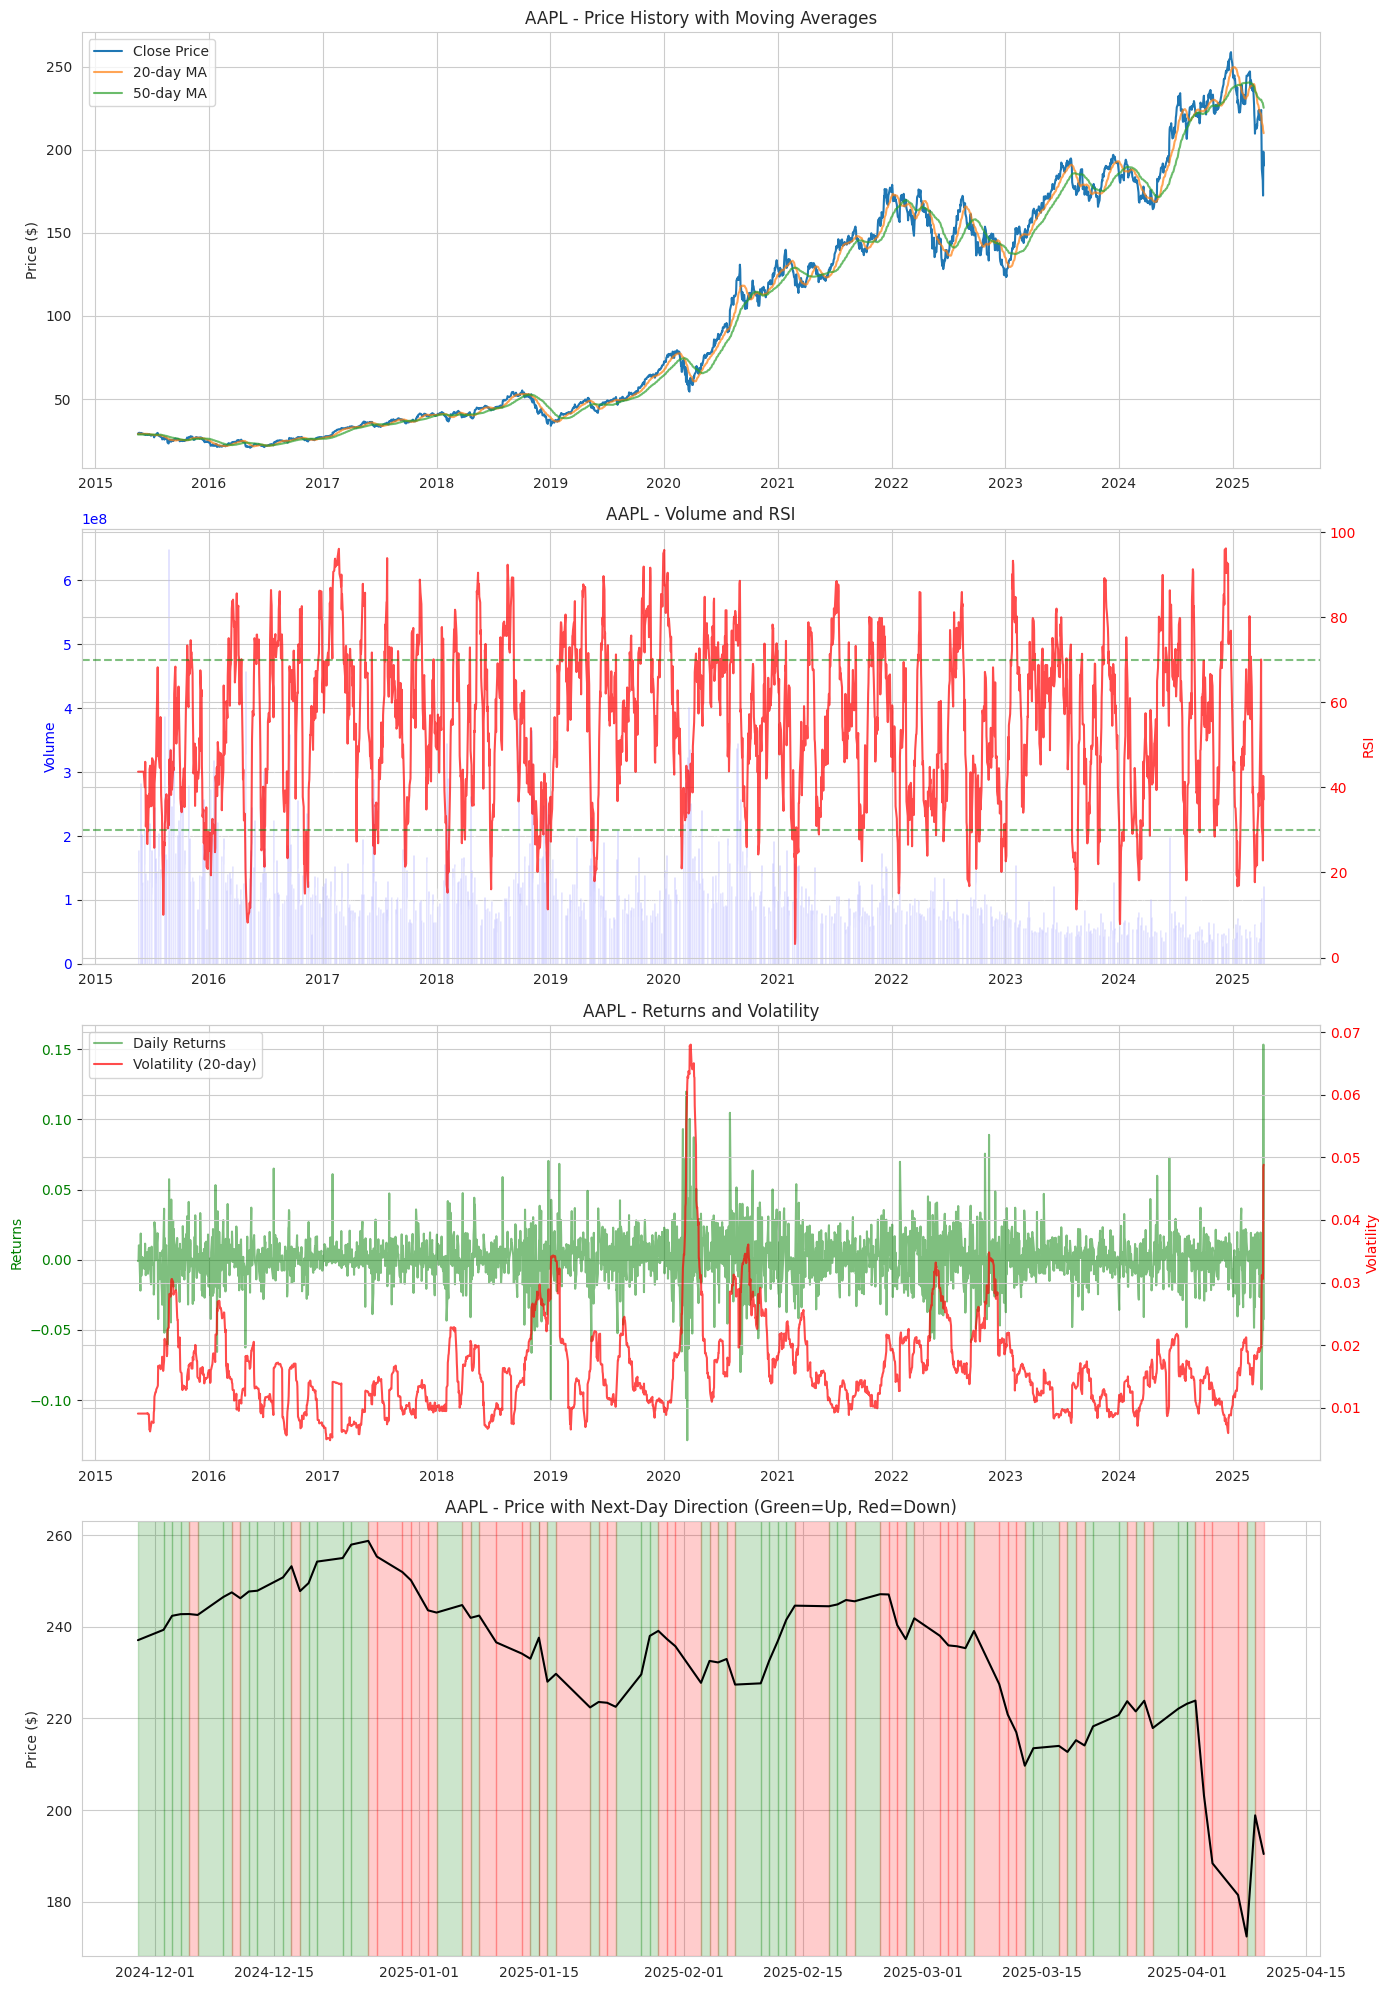

<Figure size 1400x600 with 0 Axes>

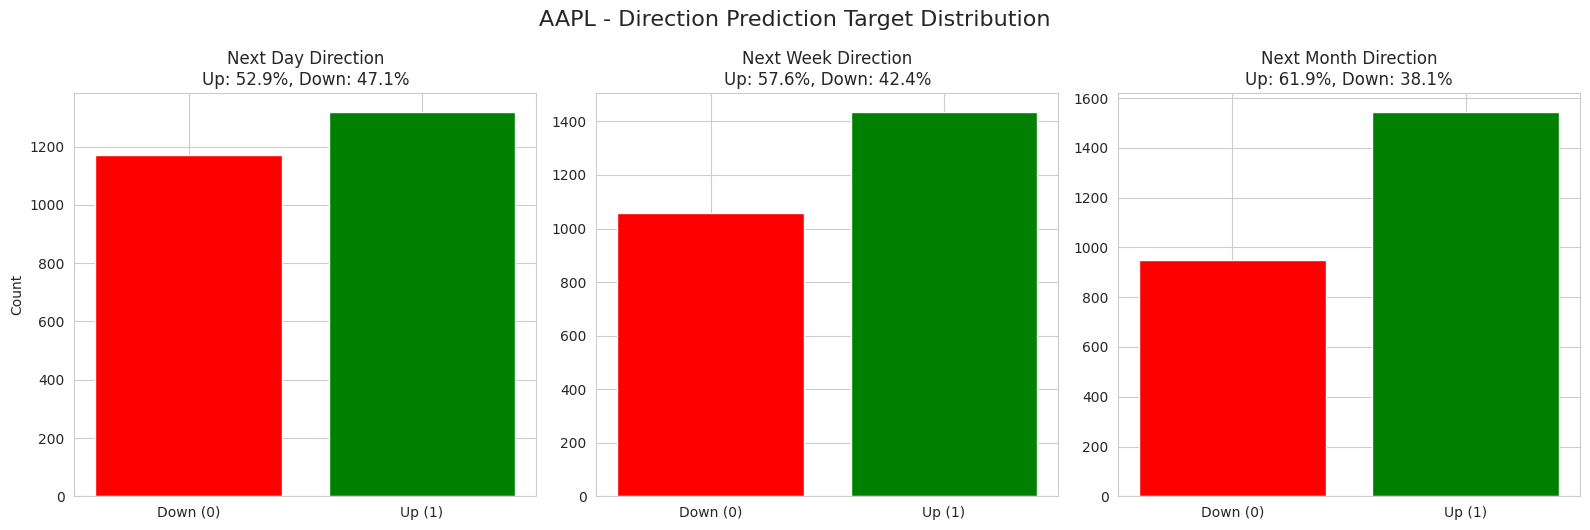

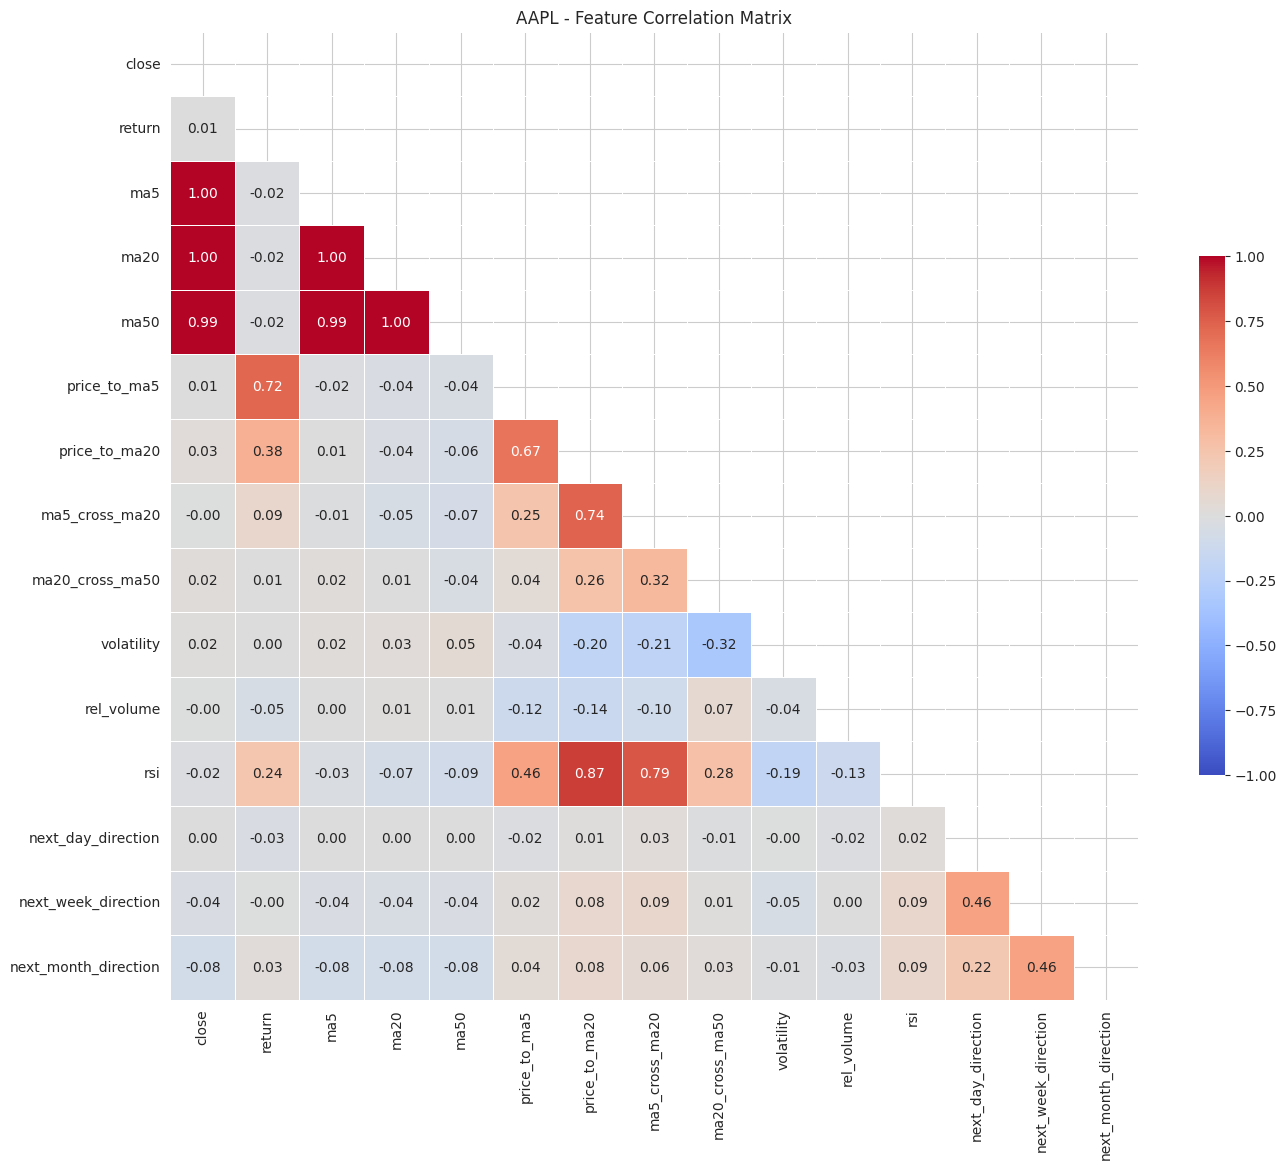


Visualizing TSLA...


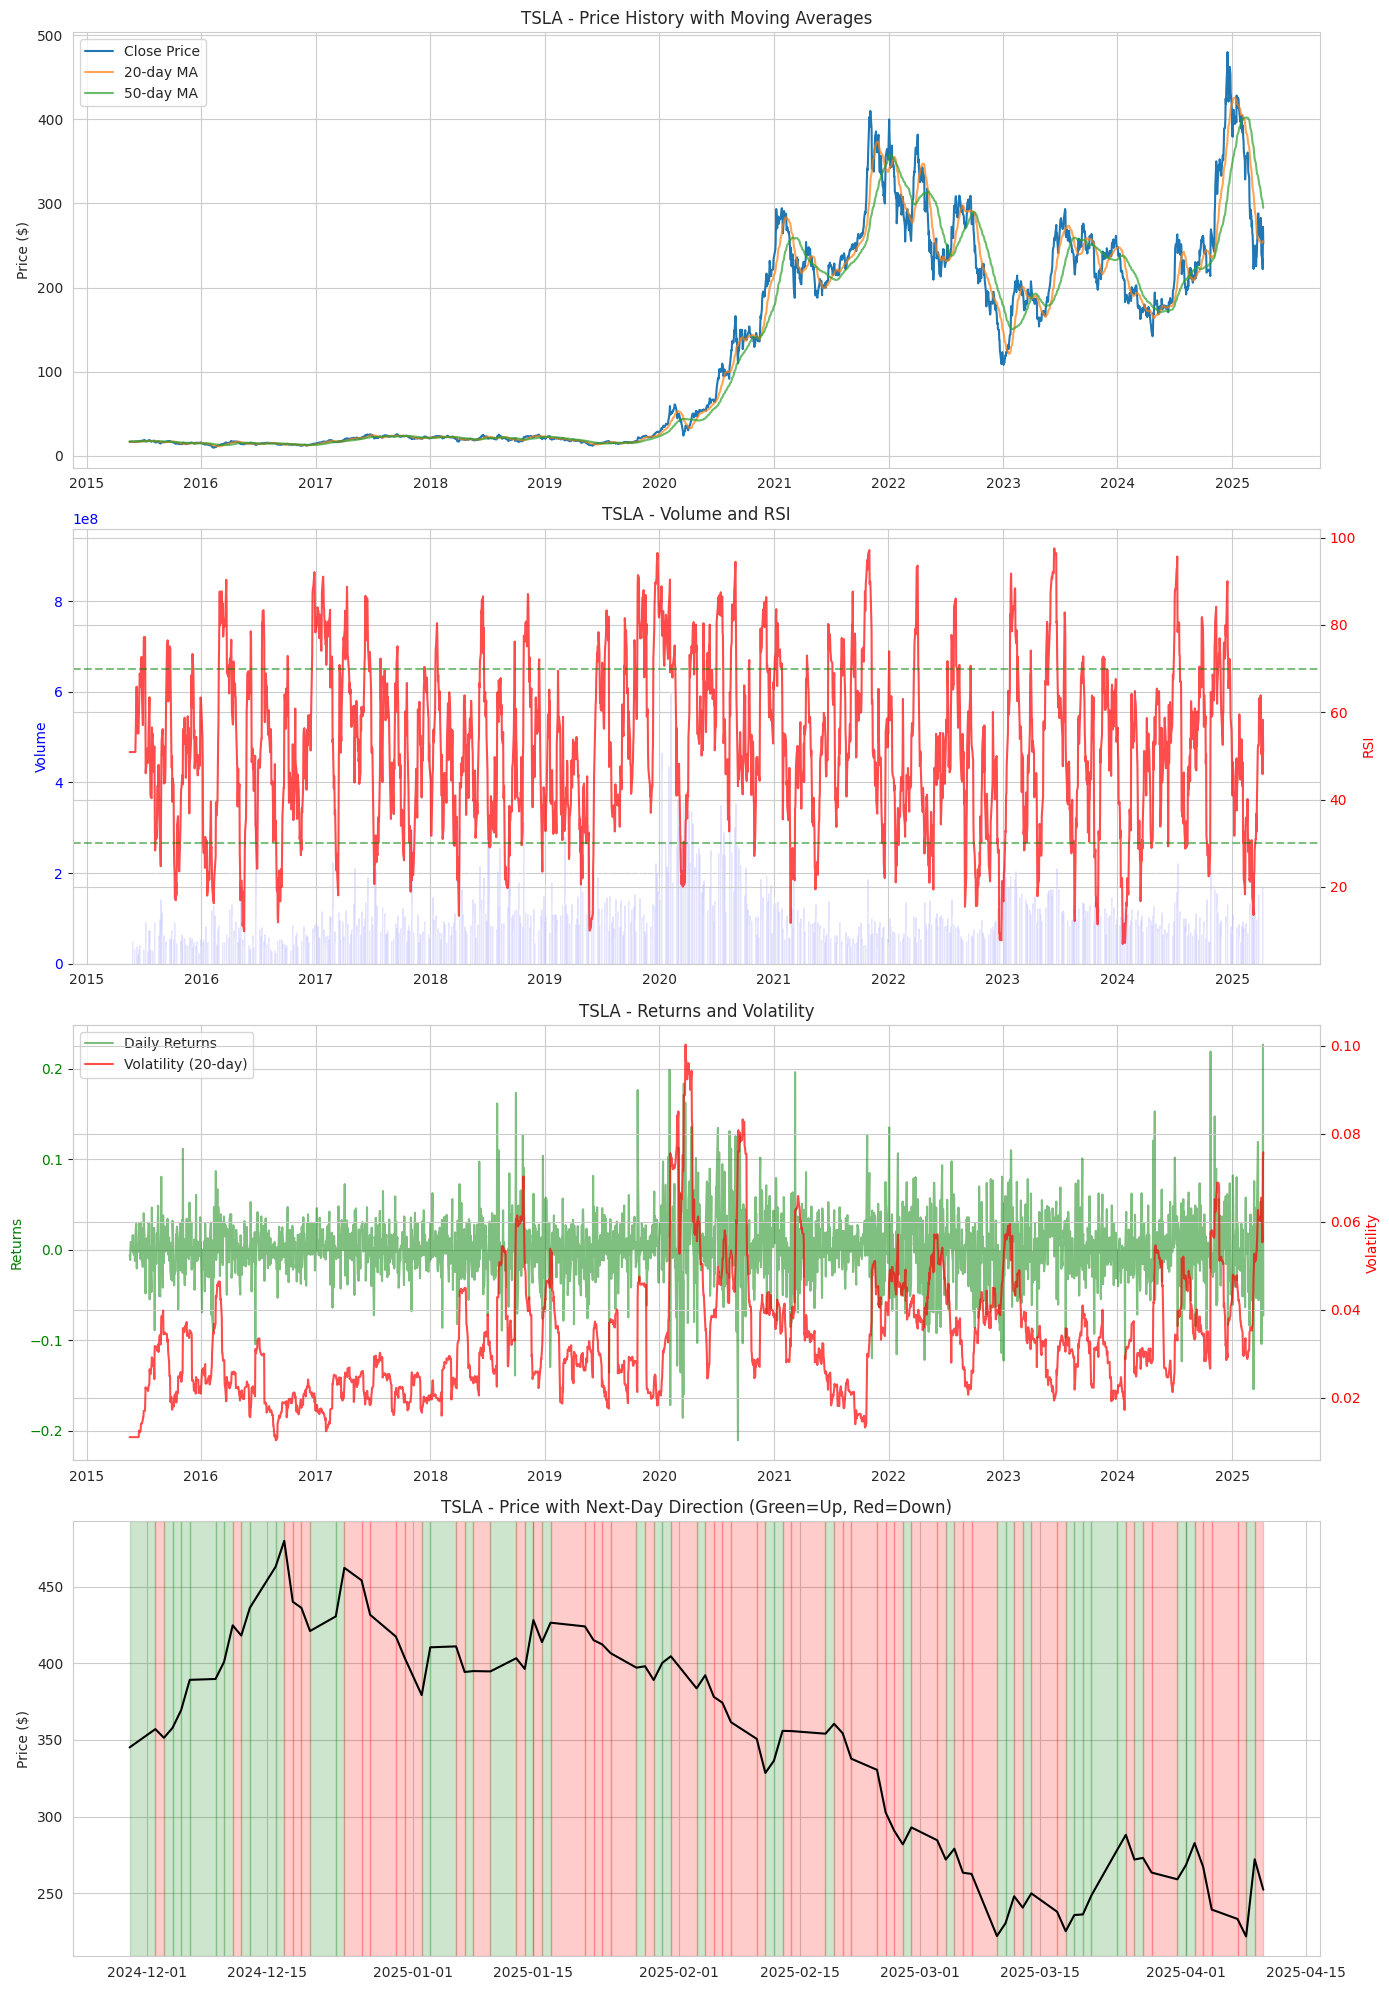

<Figure size 1400x600 with 0 Axes>

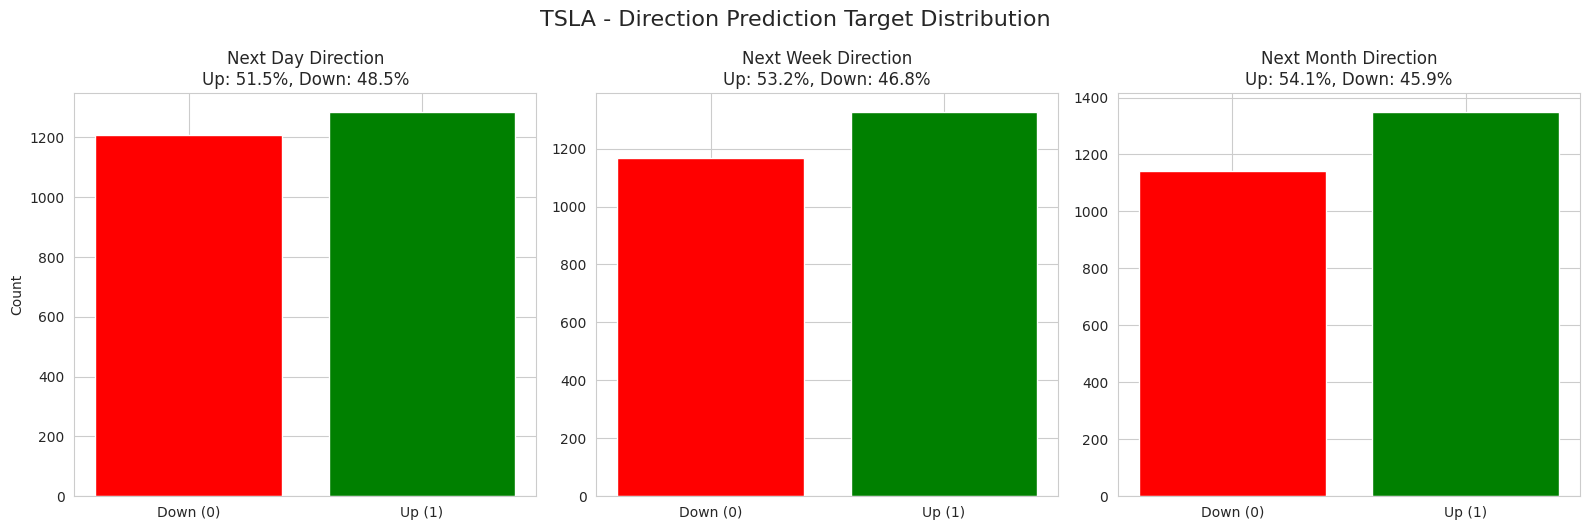

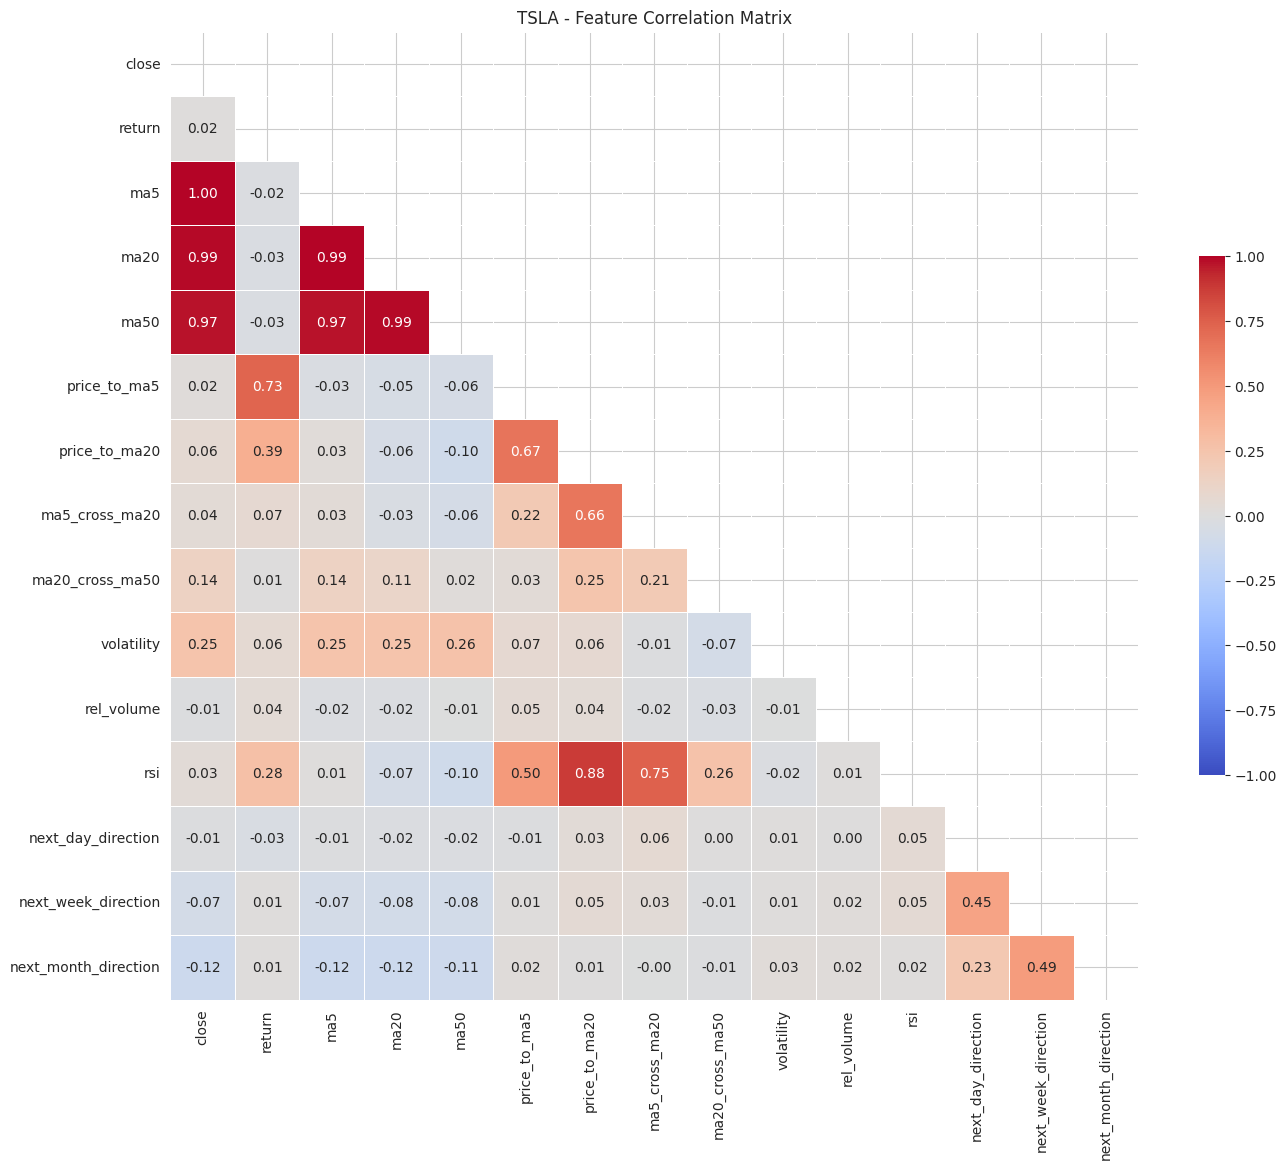


Visualizing NVDA...


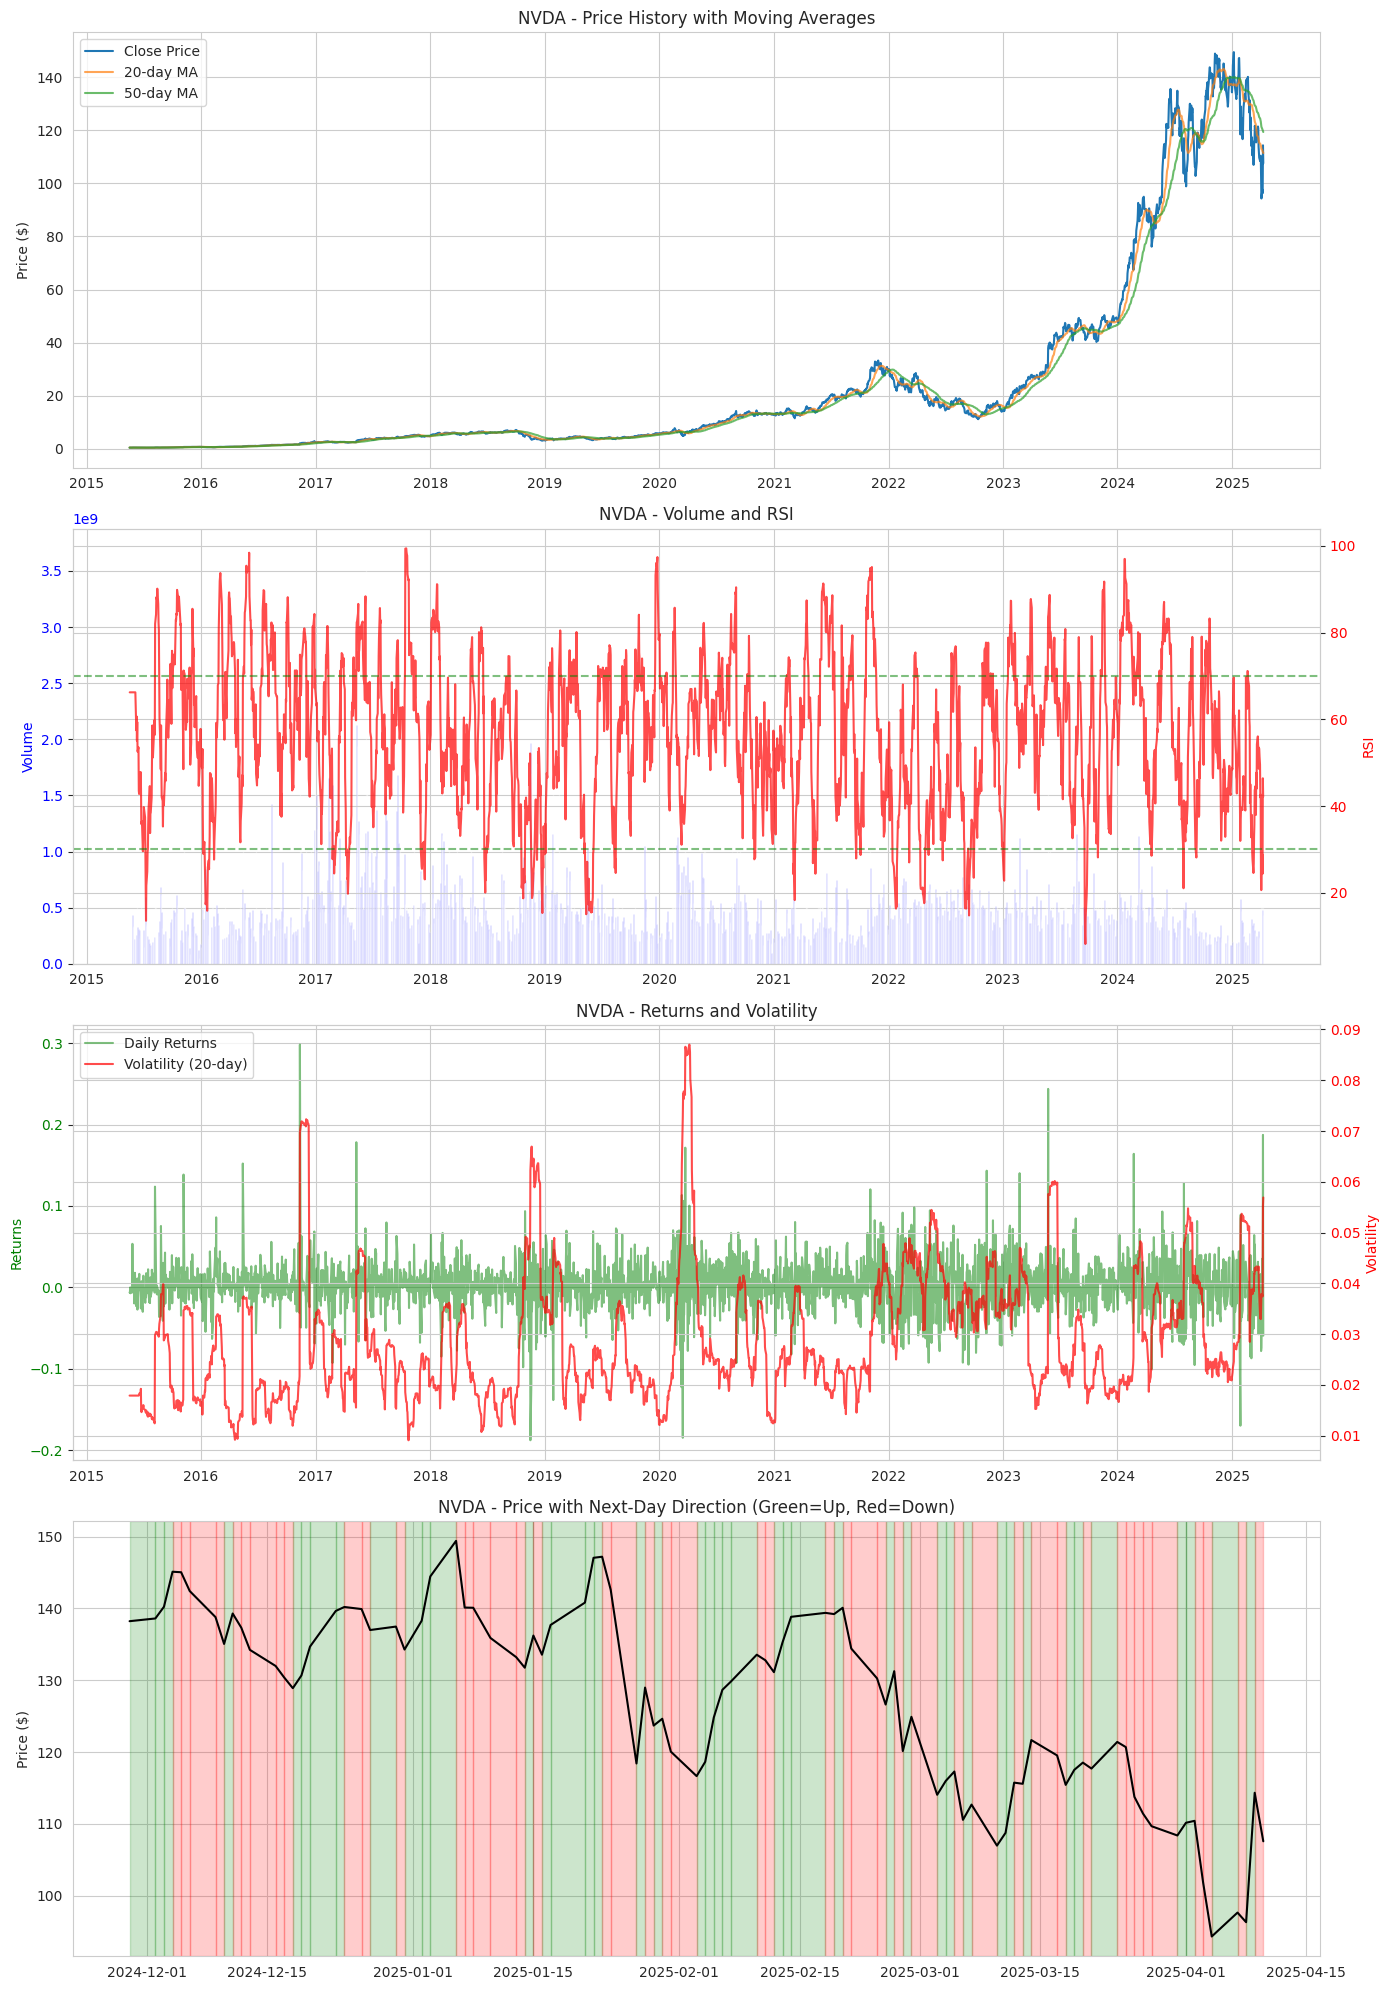

<Figure size 1400x600 with 0 Axes>

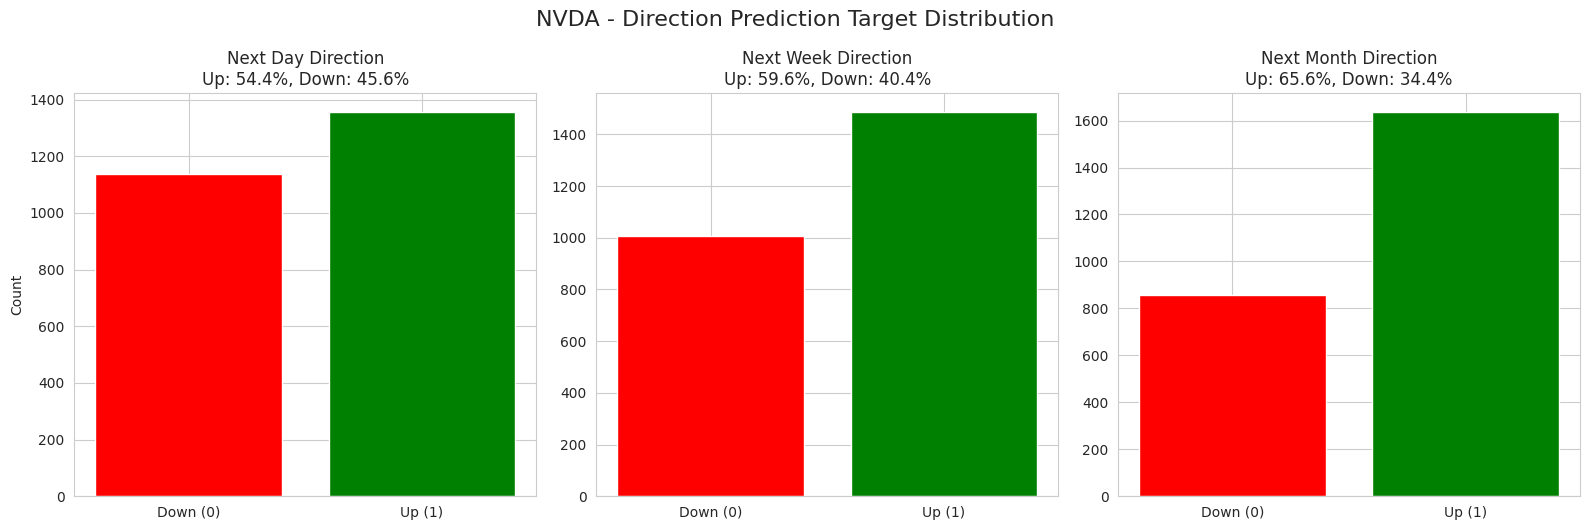

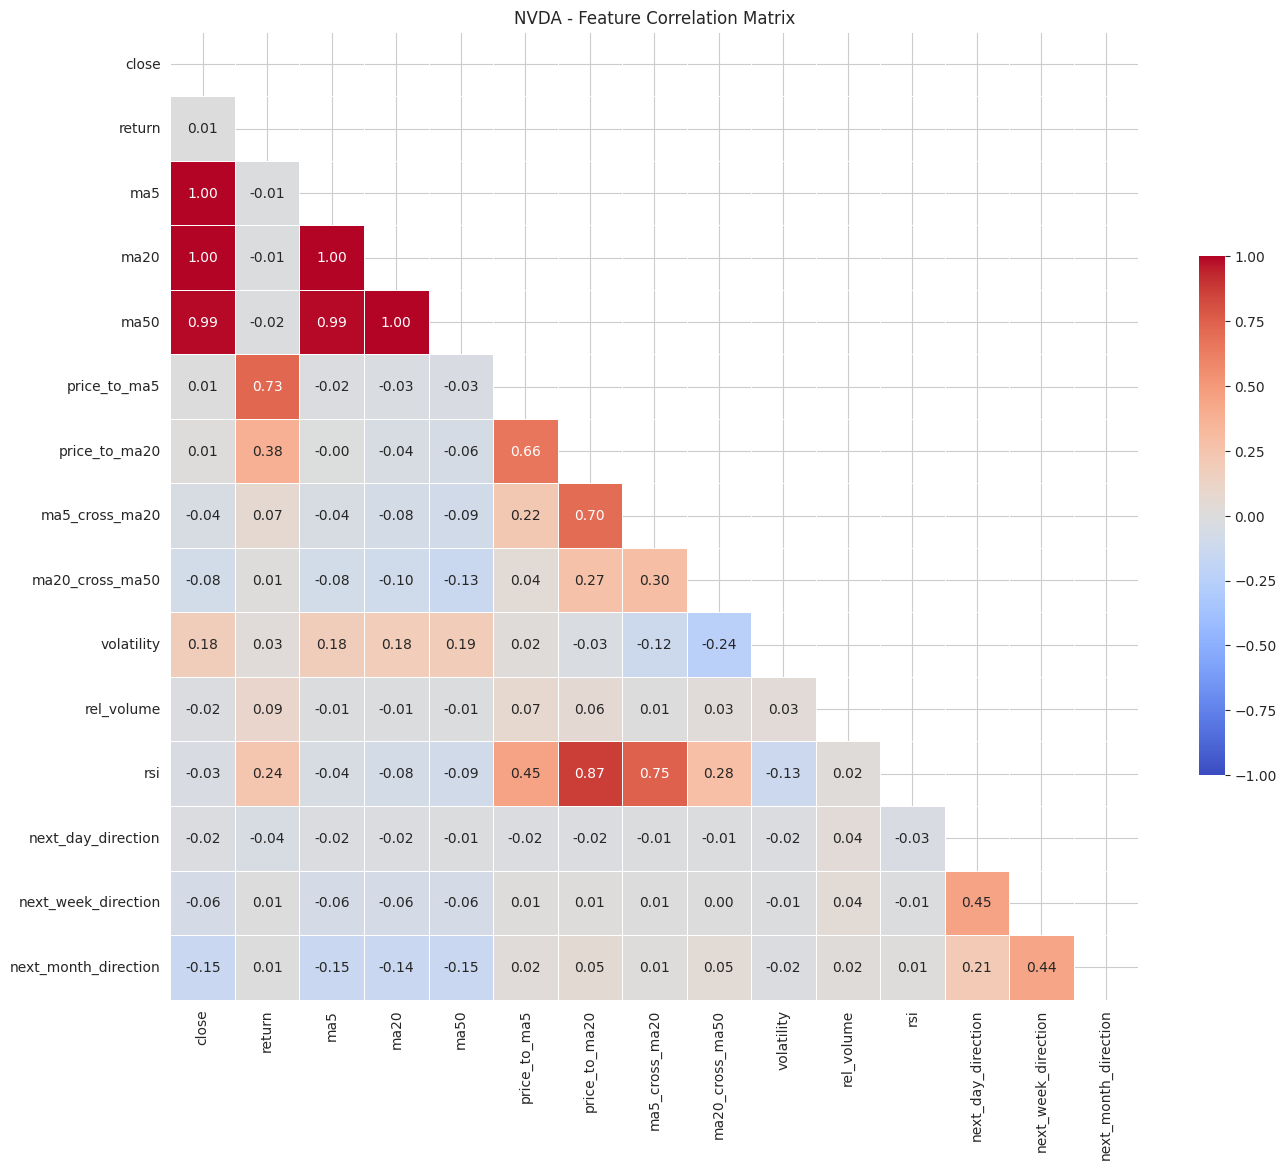


Visualizing AMZN...


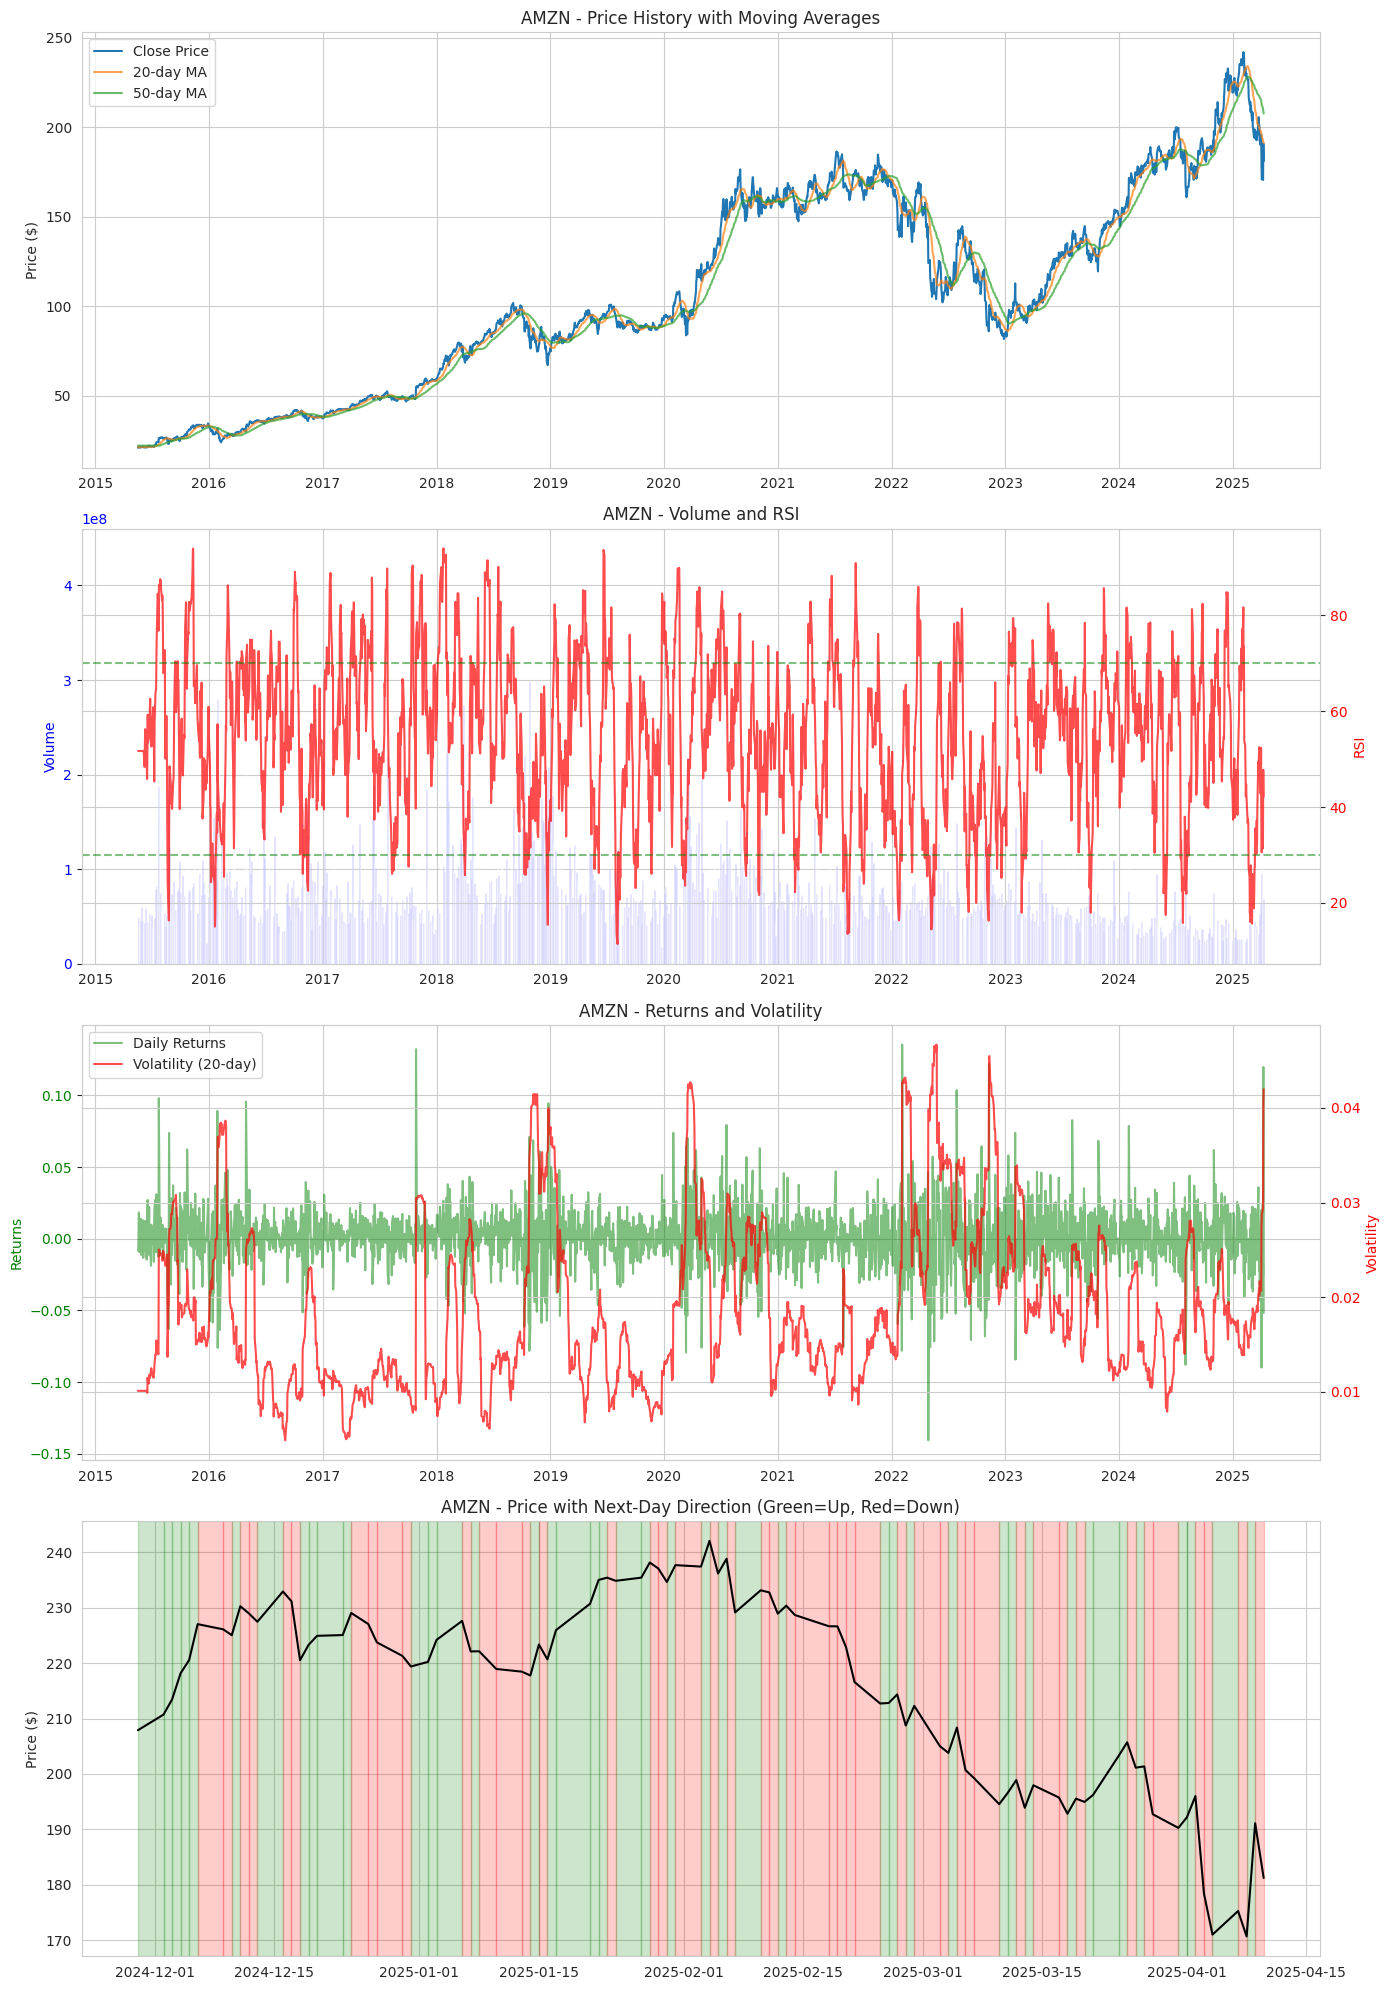

<Figure size 1400x600 with 0 Axes>

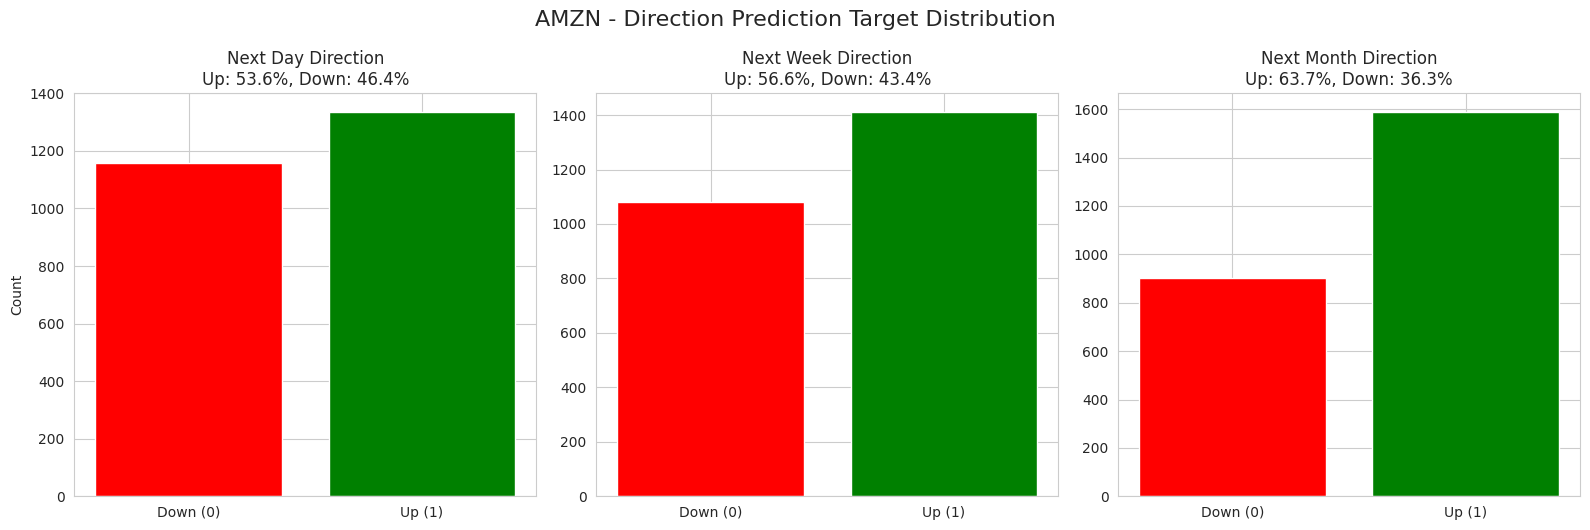

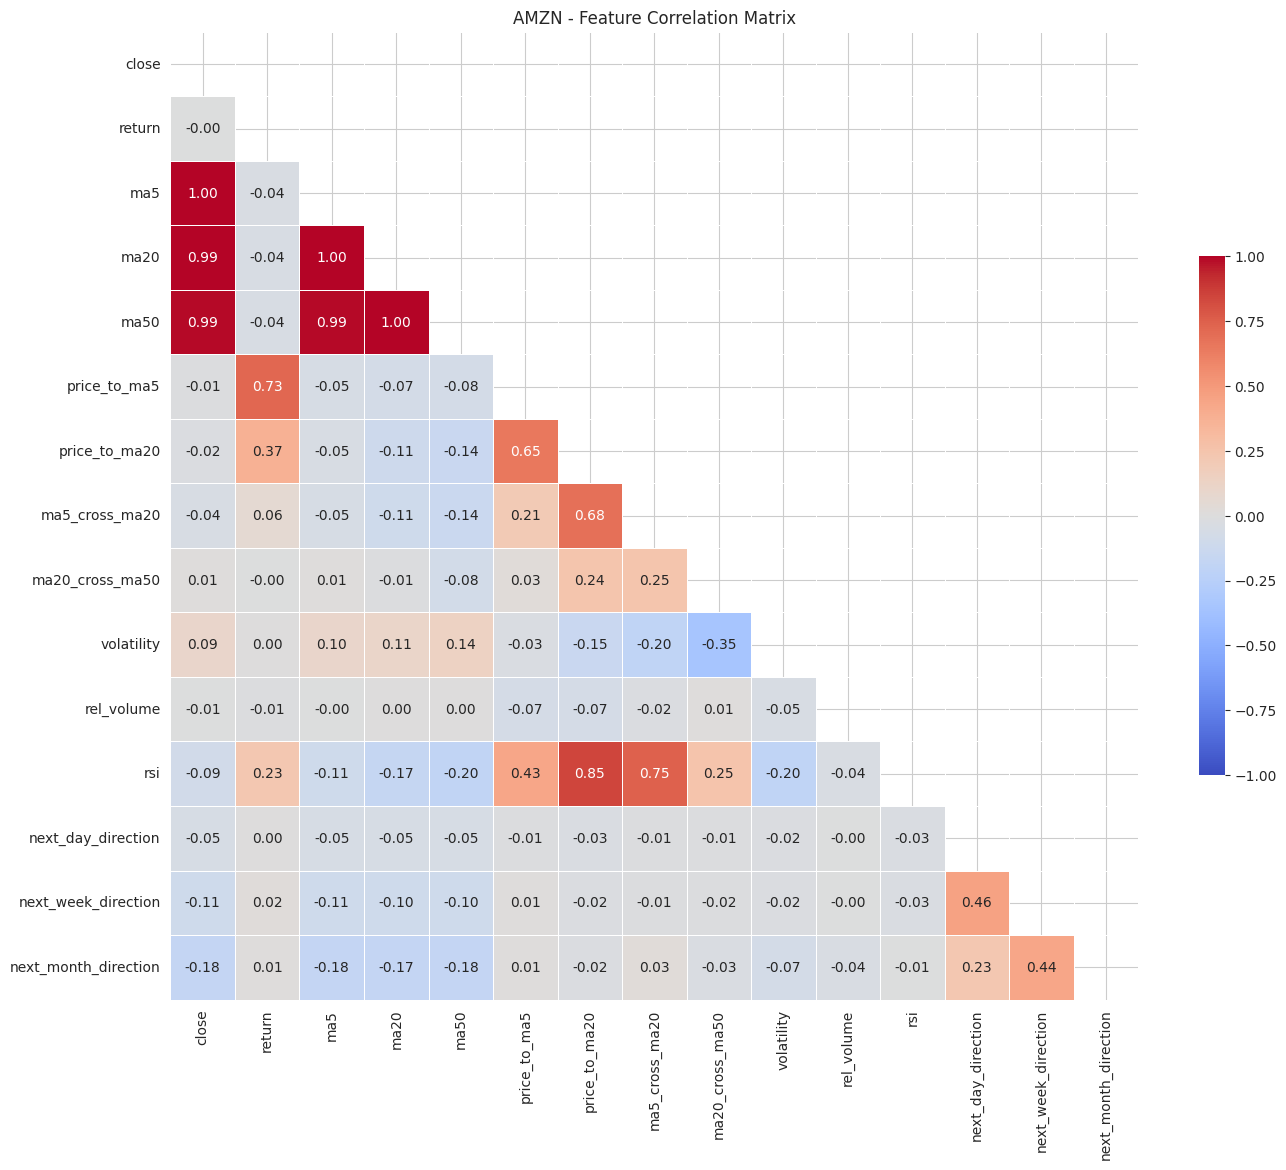

In [9]:
# Visualize a few selected stocks
sample_stocks = ['AAPL', 'TSLA', 'NVDA', 'AMZN']

for ticker in sample_stocks:
    if ticker in results:
        print(f"\nVisualizing {ticker}...")
        visualize_stock_data(results[ticker], ticker)

## 8. Data Quality Checks

Let's perform some additional data quality checks to verify our datasets are ready for model training.

Class balance (% Up) for all stocks:


,Next Day % Up,Next Week % Up,Next Month % Up
AAPL,52.910478,57.567242,61.942995
MSFT,53.552790,57.767965,64.351666
GOOG,54.034524,56.362906,61.300682
AMZN,53.552790,56.603774,63.709354
TSLA,51.545564,53.191489,54.114813
META,52.749900,55.640305,61.501405
NVDA,54.395825,59.614613,65.636291
SPY,54.636692,59.935769,66.037736
V,55.078282,58.450422,63.187475
DIS,50.100361,51.023685,49.458049


<Figure size 1200x600 with 0 Axes>

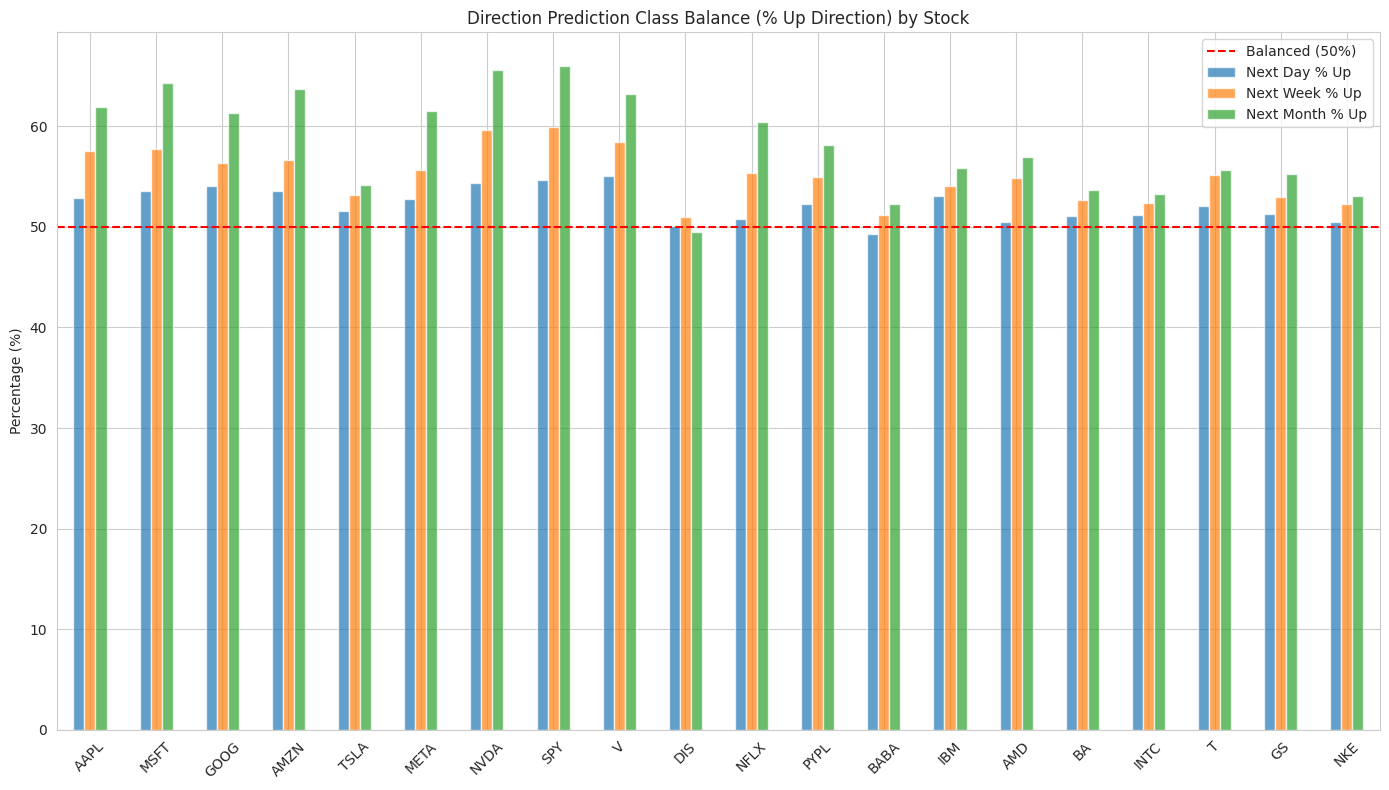

In [10]:
# Display class balance statistics for all stocks
class_balance = {}

for ticker, df in results.items():
    day_up_pct = 100 * df['next_day_direction'].mean()
    week_up_pct = 100 * df['next_week_direction'].mean()
    month_up_pct = 100 * df['next_month_direction'].mean()
    
    class_balance[ticker] = {
        'day_up': day_up_pct,
        'week_up': week_up_pct,
        'month_up': month_up_pct
    }

class_balance_df = pd.DataFrame(class_balance).T
class_balance_df.columns = ['Next Day % Up', 'Next Week % Up', 'Next Month % Up']

# Add overall average
class_balance_df.loc['AVERAGE'] = class_balance_df.mean()

print("Class balance (% Up) for all stocks:")
display(class_balance_df)

# Visualize class balance
plt.figure(figsize=(12, 6))
class_balance_df.iloc[:-1].plot(kind='bar', alpha=0.7)
plt.axhline(y=50, color='r', linestyle='--', label='Balanced (50%)')
plt.title('Direction Prediction Class Balance (% Up Direction) by Stock')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 9. Examine Feature Importance

Let's examine which features might be most important for direction prediction across all stocks.

Average feature correlation with direction targets across all stocks:


,avg_day_direction,avg_week_direction,avg_month_direction
return,-0.028202,-0.009526,-0.008846
ma5,-0.013003,-0.042179,-0.094406
ma20,-0.012471,-0.042077,-0.093326
ma50,-0.012313,-0.041267,-0.091806
price_to_ma5,-0.022391,-0.012541,-0.008626
price_to_ma20,-0.017073,-0.006596,-0.007714
price_to_ma50,-0.011455,-0.006794,-0.008877
ma5_cross_ma20,-0.004508,0.001027,0.000032
ma20_cross_ma50,0.003428,0.007752,0.013955
volatility,-0.014495,-0.012584,0.000776


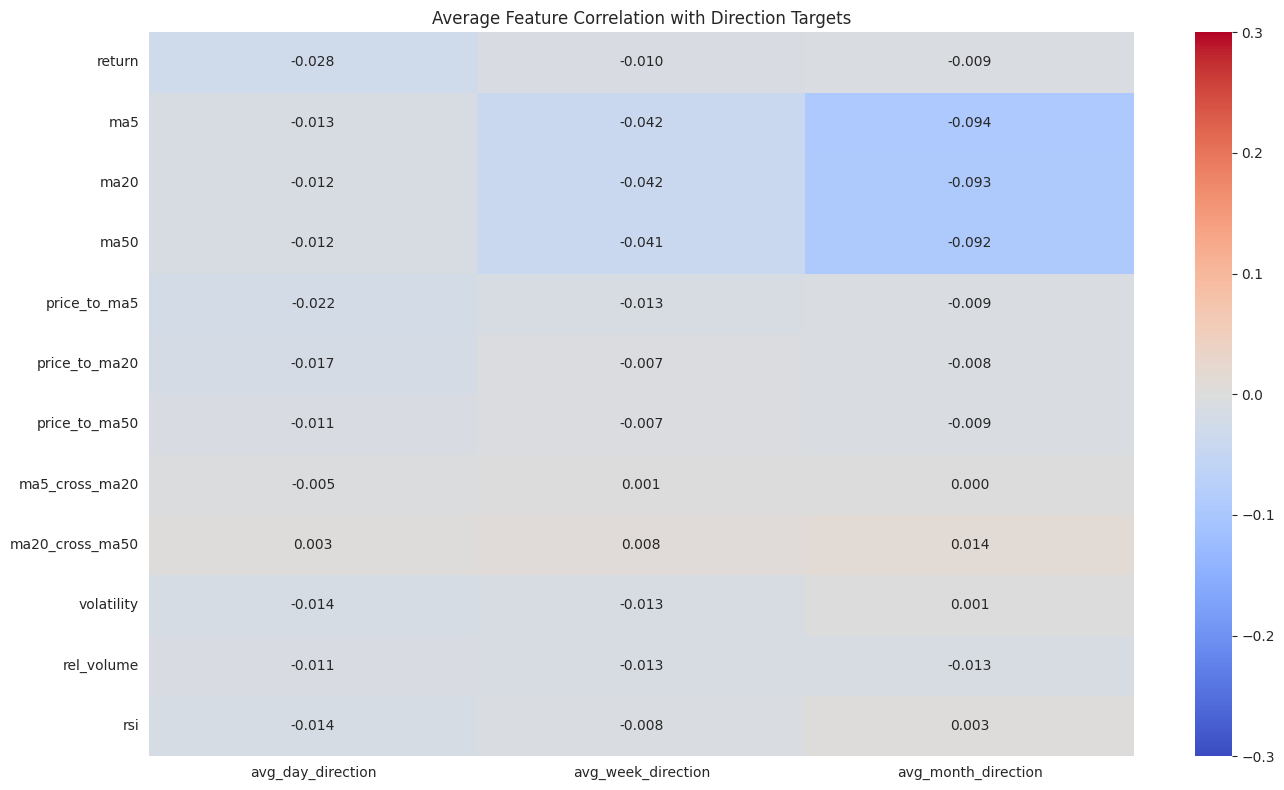

In [11]:
# Create an aggregated correlation matrix for all stocks
all_corrs = []

features = [
    'return', 'ma5', 'ma20', 'ma50', 'price_to_ma5', 'price_to_ma20', 'price_to_ma50',
    'ma5_cross_ma20', 'ma20_cross_ma50', 'volatility', 'rel_volume', 'rsi'
]

targets = ['next_day_direction', 'next_week_direction', 'next_month_direction']

for ticker, df in results.items():
    # Calculate correlation between features and targets
    corr = pd.DataFrame(index=features)
    
    for target in targets:
        corr[f"{target}_{ticker}"] = [df[feature].corr(df[target]) for feature in features]
    
    all_corrs.append(corr)

# Combine all correlations
combined_corr = pd.concat(all_corrs, axis=1)

# Calculate average correlation for each feature and target horizon
avg_corr = pd.DataFrame(index=features)

for target in targets:
    target_cols = [col for col in combined_corr.columns if col.startswith(target)]
    avg_corr[target.replace('next_', 'avg_')] = combined_corr[target_cols].mean(axis=1)

# Sort features by absolute correlation for each target
for col in avg_corr.columns:
    avg_corr[f"{col}_abs"] = avg_corr[col].abs()

day_sorted = avg_corr.sort_values('avg_day_direction_abs', ascending=False)
week_sorted = avg_corr.sort_values('avg_week_direction_abs', ascending=False)
month_sorted = avg_corr.sort_values('avg_month_direction_abs', ascending=False)

# Display average correlations
print("Average feature correlation with direction targets across all stocks:")
display(avg_corr[['avg_day_direction', 'avg_week_direction', 'avg_month_direction']])

# Visualize top features by correlation
plt.figure(figsize=(14, 8))

# Create a heatmap of average correlations
sns.heatmap(
    avg_corr[['avg_day_direction', 'avg_week_direction', 'avg_month_direction']],
    annot=True,
    cmap='coolwarm',
    vmin=-0.3,
    vmax=0.3,
    center=0,
    fmt='.3f'
)

plt.title('Average Feature Correlation with Direction Targets')
plt.tight_layout()
plt.show()

## 10. Conclusion and Next Steps

We have successfully:
1. Fetched 10 years of historical data for 20 stocks
2. Cleaned and processed the data
3. Added derived features relevant for direction prediction (moving averages, RSI, price/MA ratios, etc.)
4. Created direction prediction targets for three time horizons: next day, next week, and next month
5. Visualized the data to understand patterns and verify correctness
6. Saved cleaned datasets to `data/cleaned/` for further processing
7. Analyzed class balance and feature importance

### Key Insights
- We've created binary classification targets for price direction prediction at 3 different time horizons
- The class balance is usually not perfectly balanced (not exactly 50/50), which is expected in real market data
- Various technical indicators show different correlation strengths with direction targets
- Longer-term direction prediction (week, month) tends to show higher correlations with technical indicators

### Next Steps
The cleaned datasets are now ready to be used in model-specific preparation notebooks for binary classification models. We'll create separate models for each prediction horizon using the same underlying dataset:

1. Day direction model: Trained to predict `next_day_direction`
2. Week direction model: Trained to predict `next_week_direction`
3. Month direction model: Trained to predict `next_month_direction`

Since we're now working with binary classification instead of regression, we'll need to use appropriate classification metrics (accuracy, precision, recall, F1 score, etc.) and models suited for classification tasks (Random Forest, XGBoost, Logistic Regression, etc.).